In [0]:
import os
import pandas as pd


In [0]:
import cv2
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [3]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
import random
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/')
raw_csv = pd.read_csv('master_rbi.csv')
beetles = pd.DataFrame()
beetles['name'] = raw_csv['Filename:']
beetles['label'] = raw_csv['Family:']
os.chdir('/content/drive/My Drive/beetles')

In [0]:
#beetles =beetles.iloc[400:420,]

In [7]:
all_jpgs = beetles.name
print(len(all_jpgs))
my_dim=28

2982


0


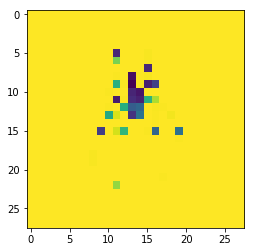

50
100
150
200
250
300


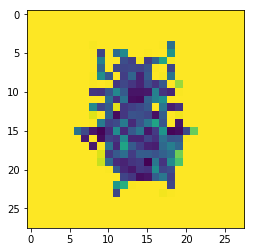

350
400
450
500
550
600


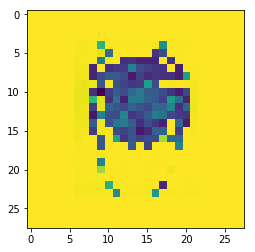

650
700
750
800
850
900


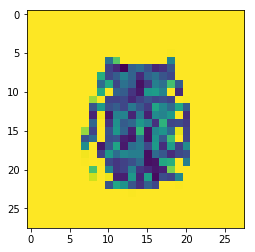

950
1000
1050
1100
1150
1200


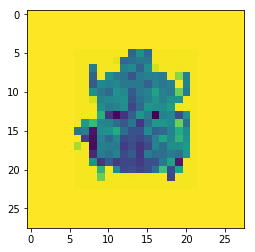

1250
1300
1350
1400
1450
1500


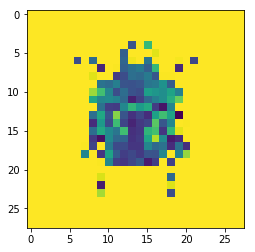

1550
1600
1650
1700
1750
1800


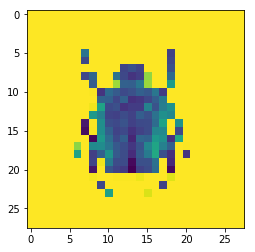

1850
1900
1950
2000
2050
2100


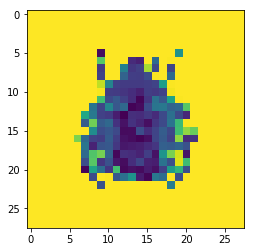

2150
2200
2250
2300
2350
2400


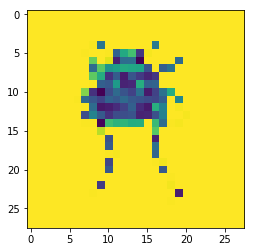

2450
2500
2550
2600
2650
2700


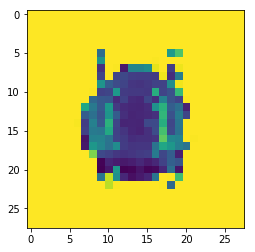

2750
2800
2850
2900
2950


In [38]:
os.chdir('/content/drive/My Drive/beetles')
data = []
labels = []
# loop over the input images
for i in range(len(all_jpgs)):#CHANGE
  if i%50 == 0:
    print(i)
	# load the image, resize the image to be 32x32 pixels (ignoring
	# aspect ratio), flatten the image into 32x32x3=3072 pixel image
	# into a list, and store the image in the data list
  filename = beetles.iloc[i,0]
  image = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2GRAY)#CHANGE

  image = cv2.resize(image, (my_dim, my_dim))
  if i%300 ==0:
    plt.imshow(image)
    plt.show()
  image = image.flatten()
  data.append(image)

	# extract the class label from the image path and update the
	# labels list
  label = beetles.iloc[i,1]
  labels.append(label)

<h2> The data is now loaded in. We will construct and run the data through the VAE> </h2>

In [0]:
# defining the key parameters
batch_size = 5
original_dim = my_dim*my_dim #200*200*3 = 120,000
latent_dim = 2
intermediate_dim = 512
epochs = 5
epsilon_std = 0.5


In [0]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

In [0]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [55]:
data.shape

(2982, 784)

In [0]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [57]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            1026        encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            1026        encoding[0][0]                   
____________________________________________________________________________________________

In [58]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
decoder_h (Dense)            (None, 512)               1536      
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [59]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [60]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(xent_loss + kl_loss)
  return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [0]:
trainX = np.array(trainX)
testX = np.array(testX)
testY = np.array(testY)
trainY = np.array(trainY)

In [62]:
trainX.shape


(2385, 784)

In [63]:
vae.fit(trainX, trainX,
        shuffle=True,
        epochs=5,
        batch_size=batch_size)

Epoch 1/5
2385/2385 [==============================] - 2s 862us/step - loss: 202.5098
Epoch 2/5
2385/2385 [==============================] - 2s 634us/step - loss: 146.9552
Epoch 3/5
2385/2385 [==============================] - 2s 631us/step - loss: 144.1488
Epoch 4/5
2385/2385 [==============================] - 2s 654us/step - loss: 143.1661
Epoch 5/5
2385/2385 [==============================] - 2s 639us/step - loss: 142.6503


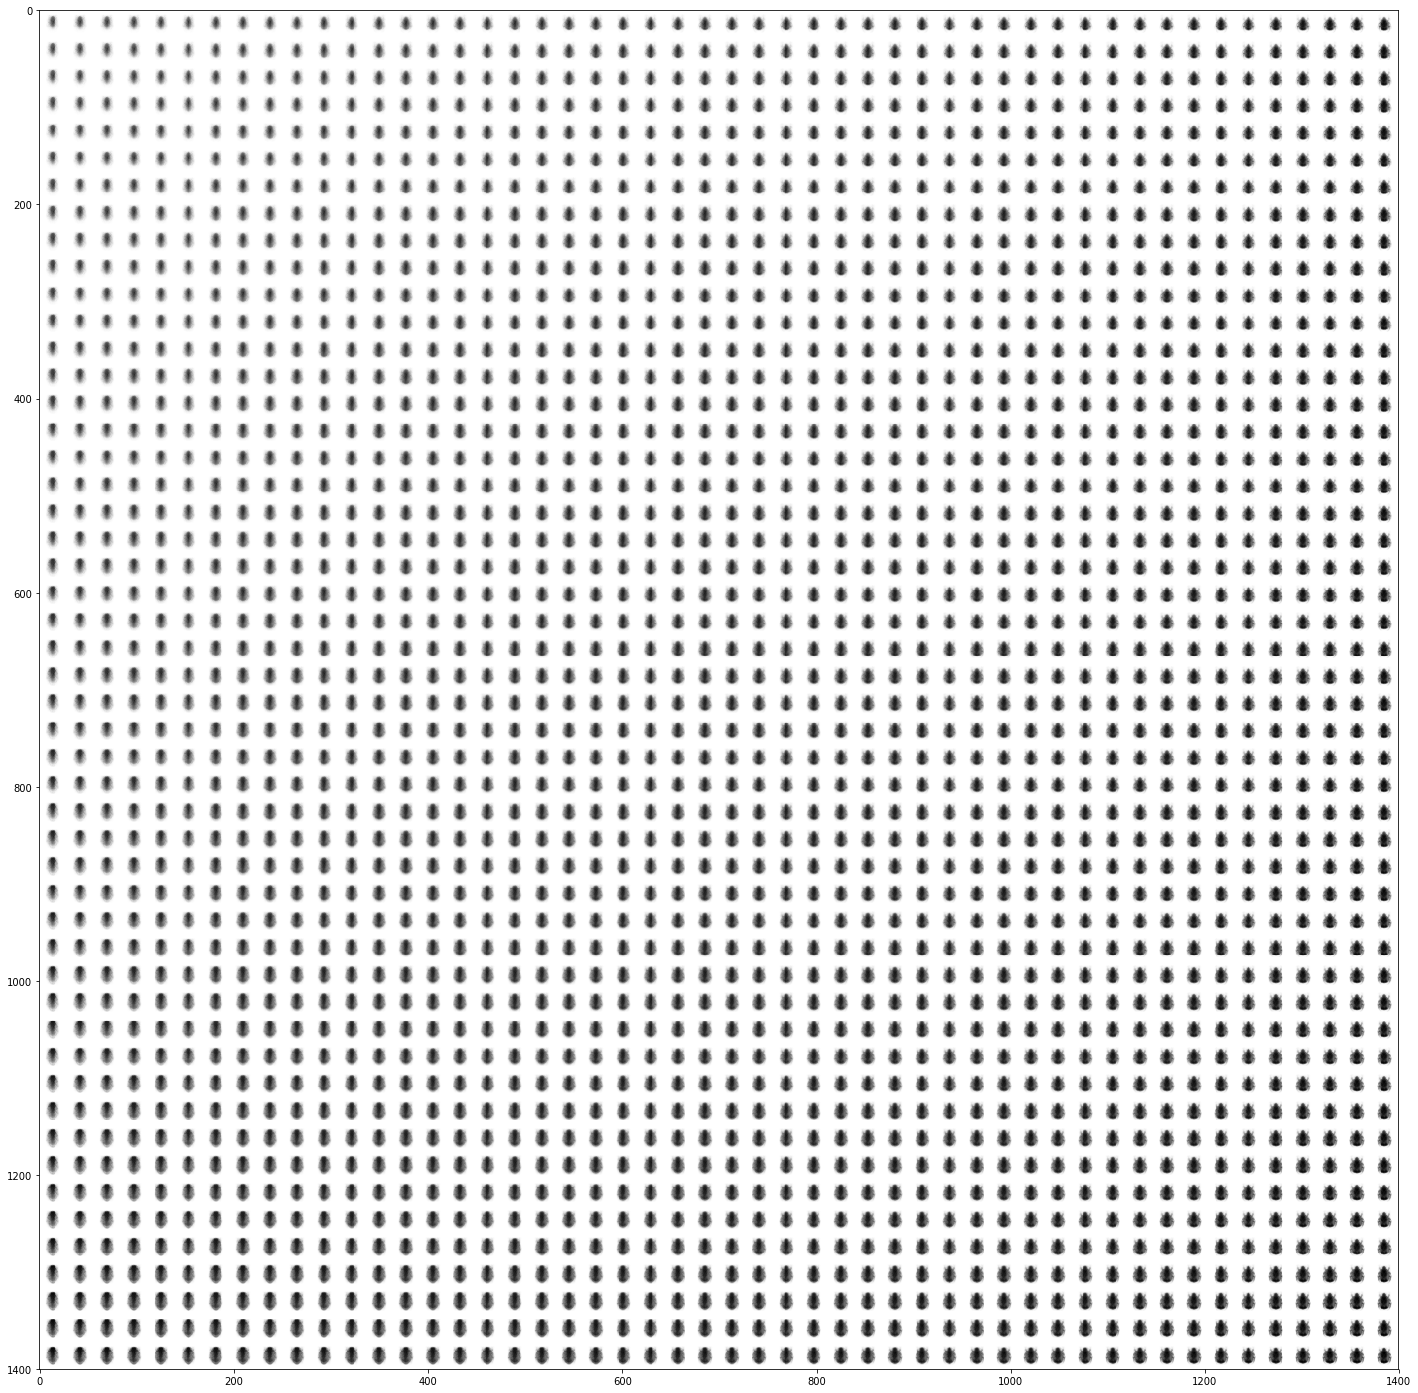

In [64]:
# display a 2D manifold of the digits
n = 50  # figure with 15x15 digits
digit_size = my_dim
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(25,   25))
plt.imshow(figure, cmap='Greys_r')
plt.show()